In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

In [128]:
%run Visulaization_Utils.ipynb

In [81]:
data_path = './Data/'
data_name_lst = [name for name in os.listdir(data_path) if name.startswith('Fill')]
data_name_lst

['FillByAll4_2020_.csv',
 'FillByAll4_2021_.csv',
 'FillByAll4_2018_.csv',
 'FillByAll4_2022_.csv',
 'FillByAll4_2019_.csv']

In [82]:
PM_data = {i.split('_')[1]: pd.read_csv(os.path.join(data_path, i)) for i in data_name_lst}

## Test with one year

In [83]:
label_path = './check_station_per_provide.csv'
label_df = meteorology_labeling(label_path)
label_dict = match_label_station(PM_data['2018'], label_df)

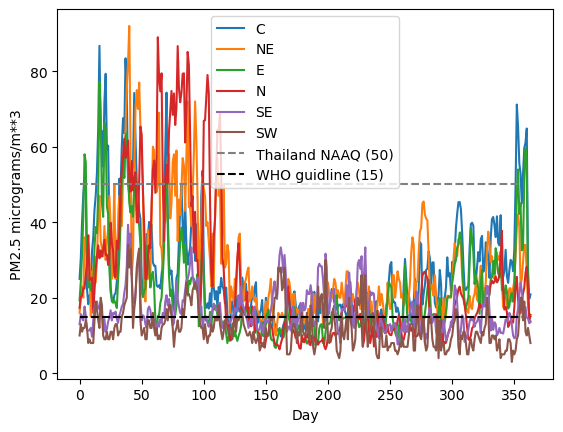

In [84]:
plot_PM_mean_curve(label_dict, label_sector=True)

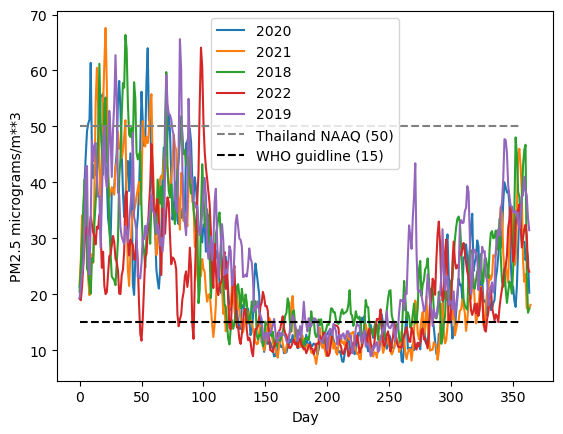

In [85]:
plot_PM_mean_curve(PM_data)

### Time series decomposition plot

In [86]:
def merge_all_year_as_timeseries(PM_data):
    all_year = pd.DataFrame(columns=['Date', 'Mean PM2.5'])
    for key, df in PM_data.items():
        mean_data = df.mean(axis=1, numeric_only=True)
        a_year_df = pd.DataFrame(df['Date'].copy().to_list(), columns=['Date'])
        a_year_df['Mean PM2.5'] = mean_data.copy().to_list()
        all_year = pd.concat([all_year, a_year_df], axis=0)

    # Add some detail
    all_year = all_year.reset_index().drop(columns=['index'])
    all_year['Date'] = all_year['Date'].apply(lambda x : datetime.strptime(x, '%Y_%m_%d'))
    all_year = all_year.drop_duplicates()
    all_year = all_year.set_index('Date').asfreq(freq='D')
    all_year['Mean PM2.5'] = all_year['Mean PM2.5'].interpolate('linear')
    return all_year

In [87]:
TS_PM_data = merge_all_year_as_timeseries(PM_data)
TS_PM_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-01-01 to 2022-12-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mean PM2.5  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


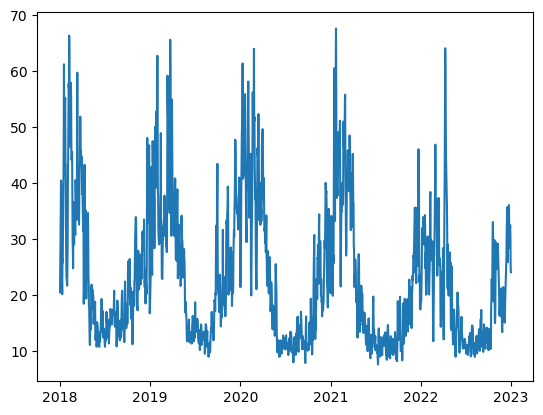

In [88]:
plt.plot(TS_PM_data.index, TS_PM_data['Mean PM2.5'])

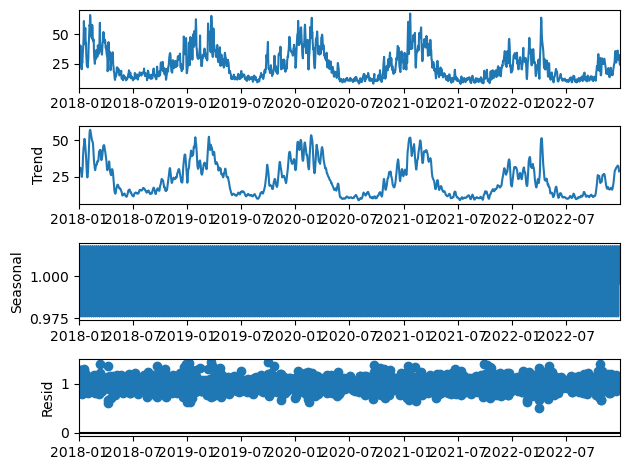

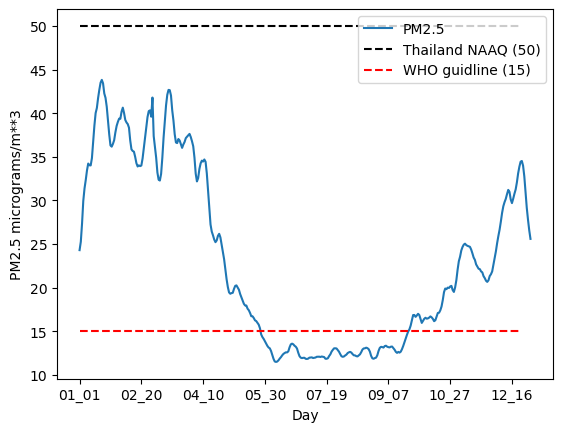

In [89]:
plot_TS_all_year(TS_PM_data, plot_result=True)

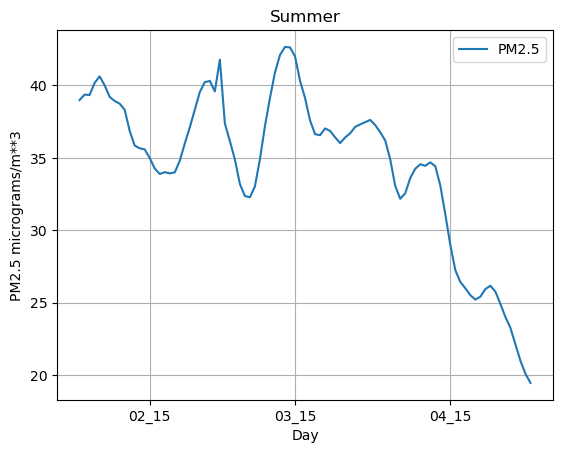

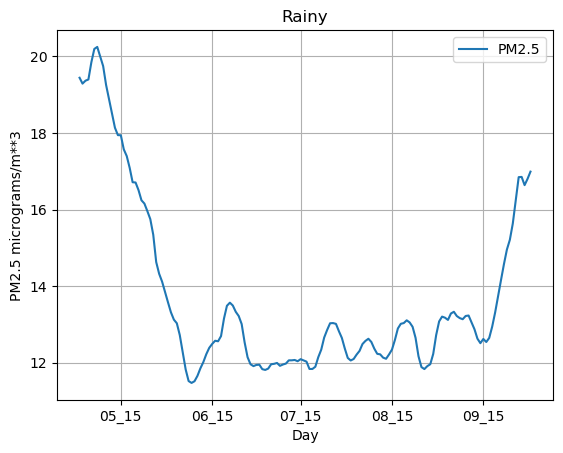

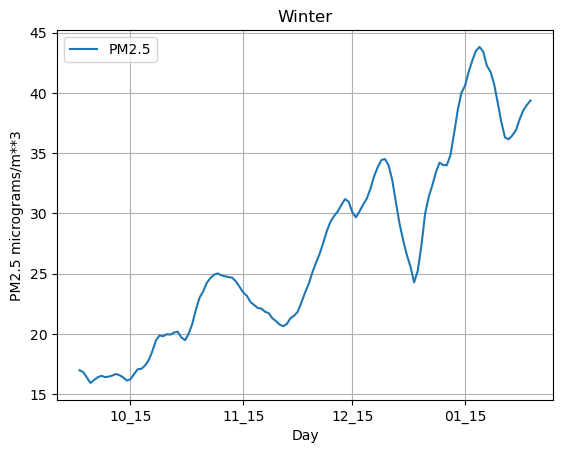

In [90]:
plot_TS_3_seasons(TS_PM_data)

### Ratio plot

In [91]:
cond_lst = [0, 50, 100, 150, np.inf]
mean_per_month_df = a_year_pollution_ratio(PM_data['2018'].copy(), cond_lst)

In [92]:
mean_per_month_df

,Month,0<=x<50,50<=x<100,100<=x<150,150<=x<inf
0,01,0.800974,0.189897,0.009130,0.0
1,02,0.633423,0.363881,0.002695,0.0
2,03,0.678028,0.312842,0.009130,0.0
3,04,0.876730,0.123270,0.000000,0.0
4,05,1.000000,0.000000,0.000000,0.0
5,06,1.000000,0.000000,0.000000,0.0
6,07,1.000000,0.000000,0.000000,0.0
7,08,0.995131,0.004869,0.000000,0.0
8,09,0.997484,0.002516,0.000000,0.0
9,10,0.990262,0.009738,0.000000,0.0


Text(0.5, 0, 'Month')

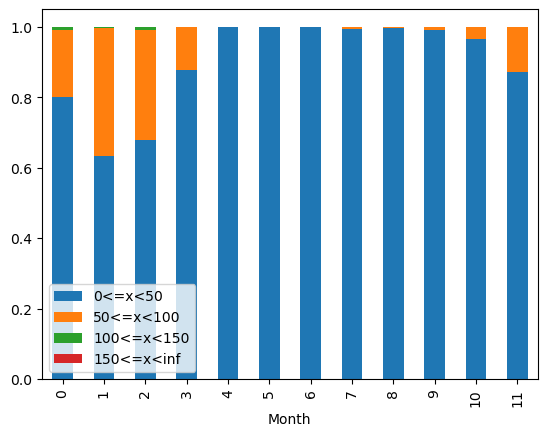

In [93]:
mean_per_month_df.plot.bar(stacked=True)
plt.xlabel('Month')

## Test with multi years

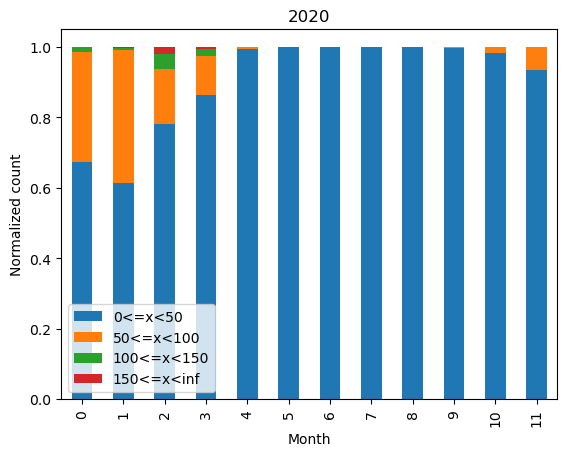

<Figure size 640x480 with 0 Axes>

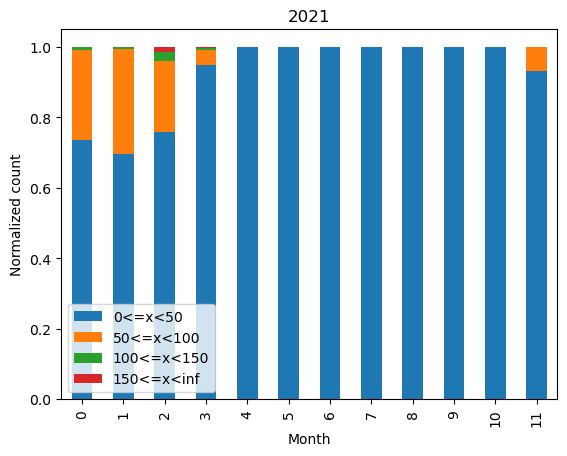

<Figure size 640x480 with 0 Axes>

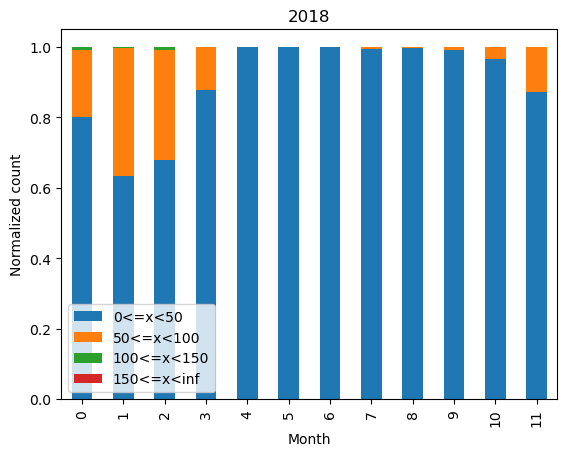

<Figure size 640x480 with 0 Axes>

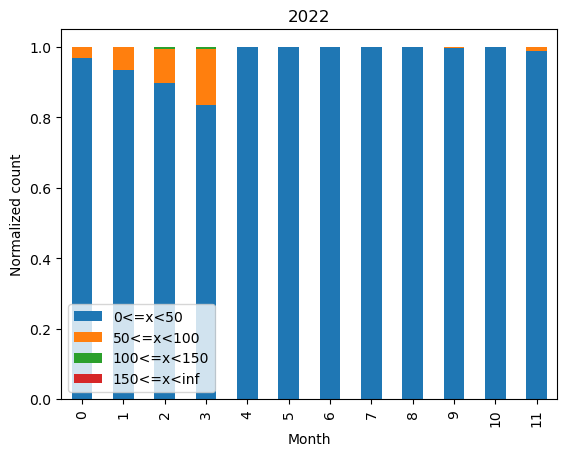

<Figure size 640x480 with 0 Axes>

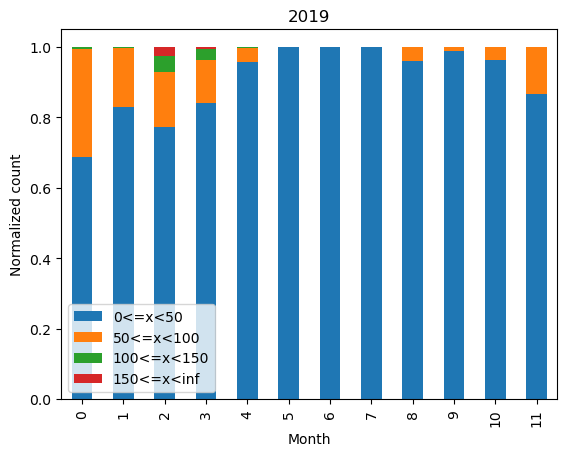

<Figure size 640x480 with 0 Axes>

In [94]:
cond_lst = [0, 50, 100, 150, np.inf]
a = []
for year, df in PM_data.items():
    mean_per_month_df = a_year_pollution_ratio(df.copy(), cond_lst)
    a.append(mean_per_month_df.copy().drop(columns=['Month']))
    mean_per_month_df.plot.bar(stacked=True)
    plt.title(year)
    plt.xlabel('Month')
    plt.ylabel('Normalized count')
    plt.pause(0.001)
    plt.clf()

month_df = pd.DataFrame(mean_per_month_df['Month'].to_list(), columns=['Month'])

In [95]:
col_name = a[0].columns
d = 0
for i in a:
    d += i.to_numpy()
d = d / len(a)
all_year_bar_df = pd.concat([month_df, pd.DataFrame(d, columns=col_name)], axis=1)

Text(0, 0.5, 'Normalized count')

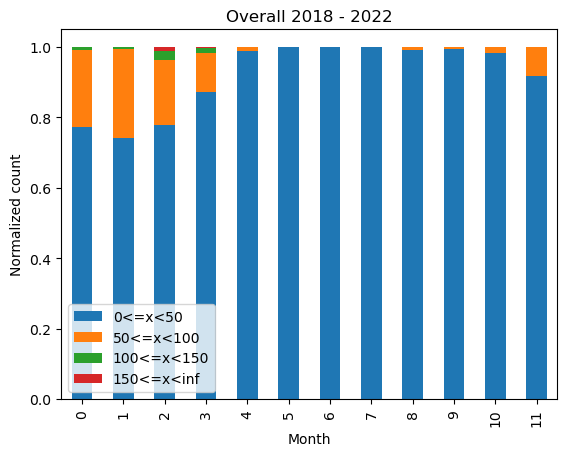

In [96]:
all_year_bar_df.plot.bar(stacked=True)
plt.title('Overall 2018 - 2022')
plt.xlabel('Month')
plt.ylabel('Normalized count')

### Find 5 provinces which are top 5 maximum of PM2.5

In [97]:
label_path = './check_station_per_provide.csv'
sector_label_df = meteorology_labeling(label_path)
provide_label_df = provide_labeling(label_path)

In [98]:
a = sector_label_df[sector_label_df['label'] == '1']
a = a.copy().drop(columns=['label'])
a['label'] = a['station_id'].apply(lambda x: provide_label_df[provide_label_df['station_id'] == x]['label'].to_list()[0])
a.head()

,station_id,station_name,label
13,94T,จ.กำแพงเพชร,2
21,76T,จ.ตาก,8
30,75T,จ.น่าน,16
31,67T,จ.น่าน,16
38,70T,จ.พะเยา,22


In [99]:
b = match_label_select_station(PM_data['2018'].copy(), a.copy())

In [100]:
def mean_province_sector(label_dict):
    mean_label_dict = {'label':[], 'Mean PM2.5':[]}
    if 'Date' in label_dict.keys():
        del label_dict['Date']
    for label, provinec_df in label_dict.items():
        val = provinec_df.to_numpy().mean()
        mean_label_dict['label'].append(int(label))
        mean_label_dict['Mean PM2.5'].append(val)
    mean_label_df = pd.DataFrame(mean_label_dict)
    return mean_label_df


In [101]:
def mean_all_year_province_sector(PM_data, label_dict):
    mean_label_dict = {str(i):0 for i in label_dict['label'].unique()}
    for a_year, df in PM_data.items():
        sector_label_dict = match_label_select_station(PM_data['2018'], label_dict)
        a_mean_label_df = mean_province_sector(sector_label_dict)
        a_mean_province_dict = a_mean_label_df.to_dict()
        for key, val in a_mean_province_dict['label'].items():
            mean_label_dict[val] += a_mean_province_dict['Mean PM2.5'][key]
    return mean_label_dict


In [102]:
def mean_all_year_province_sector(PM_data, label_df):
    main_df = pd.DataFrame({'label':label_df['label'].unique()}).set_index(['label'])
    data_lst = [main_df]
    for year, year_PM_data in PM_data.items():
        b = match_label_select_station(year_PM_data.copy(), label_df.copy())
        mean_label_df = mean_province_sector(b.copy())
        data_lst.append(mean_label_df.copy().rename(columns={'Mean PM2.5':year}).set_index('label'))
    return pd.concat(data_lst, axis=1).reset_index()

In [103]:
c = mean_all_year_province_sector(PM_data, a.copy())

In [104]:
c['total'] = c.drop(columns=['label']).mean(axis=1)
c = c.fillna(0)
c

,label,2020,2021,2018,2022,2019,total
0,2,0.000000,0.000000,0.000000,20.363693,0.000000,20.363693
1,8,27.487179,25.314612,29.090316,20.331319,27.960165,26.036718
2,16,28.280220,22.319064,18.518838,22.589171,29.357830,24.213025
3,22,32.085165,25.127397,25.394893,20.494505,31.603508,26.941094
4,23,0.000000,0.000000,0.000000,21.880177,0.000000,21.880177
5,24,0.000000,25.315719,0.000000,22.791209,0.000000,24.053464
6,31,27.345009,24.088242,24.625687,18.939858,29.643429,24.928445
7,32,27.217033,22.894977,26.373473,21.871566,35.065934,26.684597
8,43,0.000000,0.000000,0.000000,22.008798,0.000000,22.008798
9,46,0.000000,26.535996,0.000000,23.465195,0.000000,25.000595


In [105]:
station_PM_perYear = pd.concat([a.copy().set_index(['label']), c.copy().set_index(['label'])], axis=1).reset_index().sort_values(['total'], ascending=False)

In [106]:
station_PM_perYear[['station_name', 'total']].groupby(['station_name']).mean().sort_values(['total'], ascending=False)

,total
station_name,
จ.เชียงราย,30.540949
จ.เชียงใหม่,28.095132
จ.แม่ฮ่องสอน,27.358922
จ.พะเยา,26.941094
จ.แพร่,26.857272
จ.ลำพูน,26.684597
จ.ตาก,26.036718
จ.อุตรดิตถ์,25.000595
จ.ลำปาง,24.928445


## Result

In [107]:
data_path = './Data/'
data_name_lst = [name for name in os.listdir(data_path) if name.startswith('Fill')]
data_name_lst

PM_data = {i.split('_')[1]: pd.read_csv(os.path.join(data_path, i)) for i in data_name_lst}
TS_PM_data = merge_all_year_as_timeseries(PM_data)

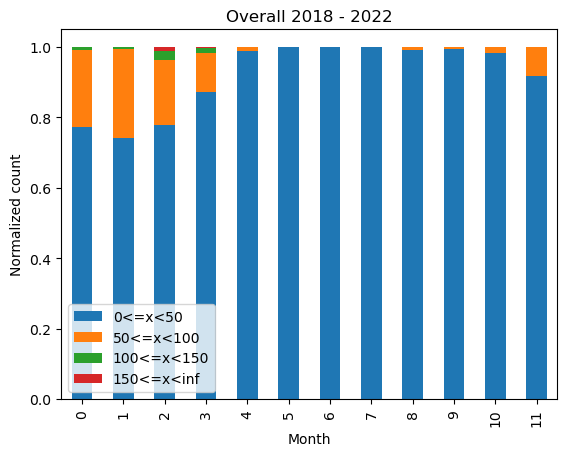

In [120]:
all_year_bar_df.plot.bar(stacked=True)
plt.title('Overall 2018 - 2022')
plt.xlabel('Month')
plt.ylabel('Normalized count')
plt.savefig('./Pics/Histogram_PM2.5_month.png')

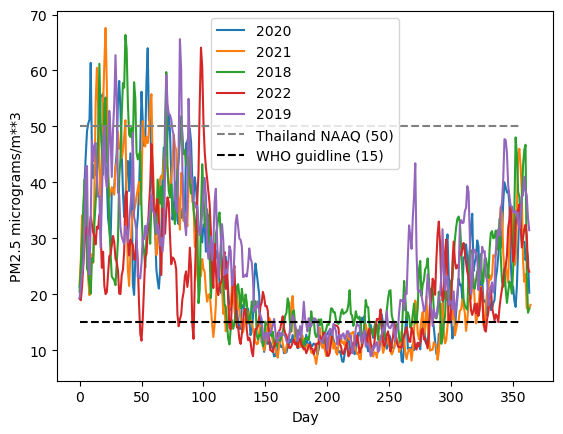

In [123]:
plot_PM_mean_curve(PM_data, save_path='./Pics/PM2.5_day_label_years.png')

When be seperated by Thailand sector
Year:  2020


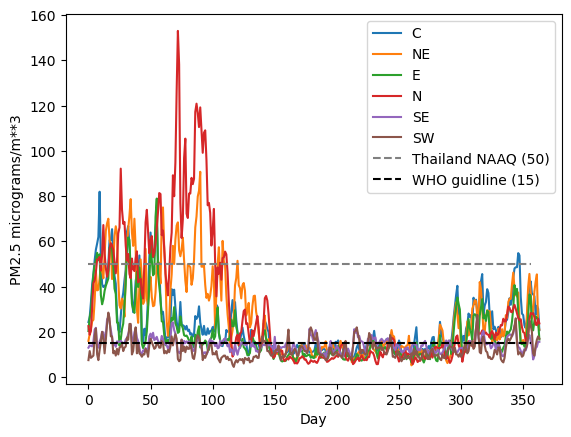

Year:  2021


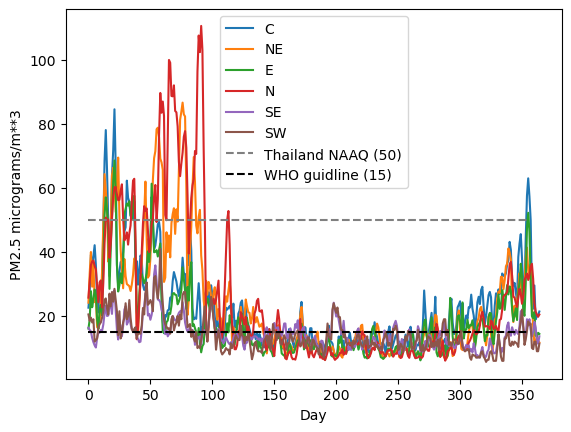

Year:  2018


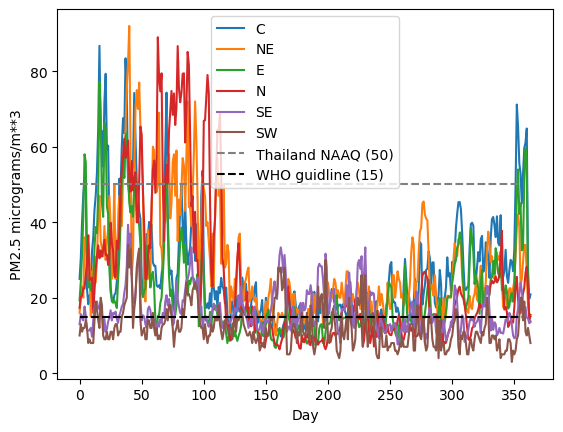

Year:  2022


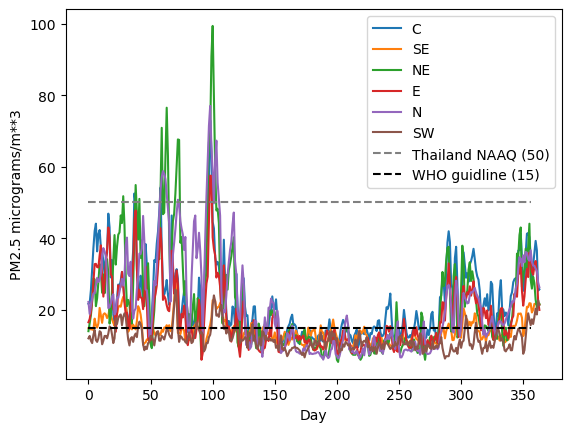

Year:  2019


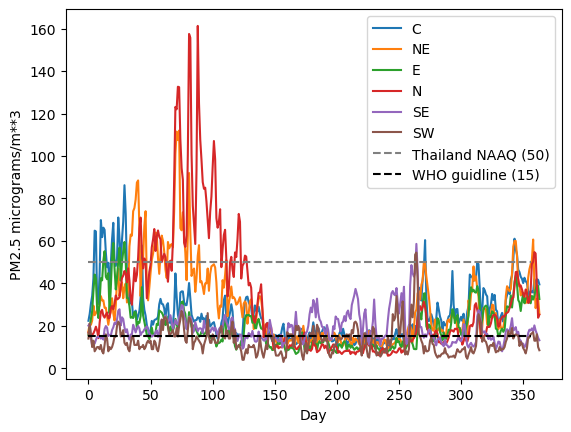

In [124]:
label_path = './check_station_per_provide.csv'
label_df = meteorology_labeling(label_path)
print('When be seperated by Thailand sector')
for year, df in PM_data.items():
    label_dict = match_label_station(df, label_df)
    print('Year: ', year)
    plot_PM_mean_curve(label_dict, label_sector=True, save_path=f'./Pics/PM2.5_day_{year}_label_sector.png')
    plt.pause(0.0001)

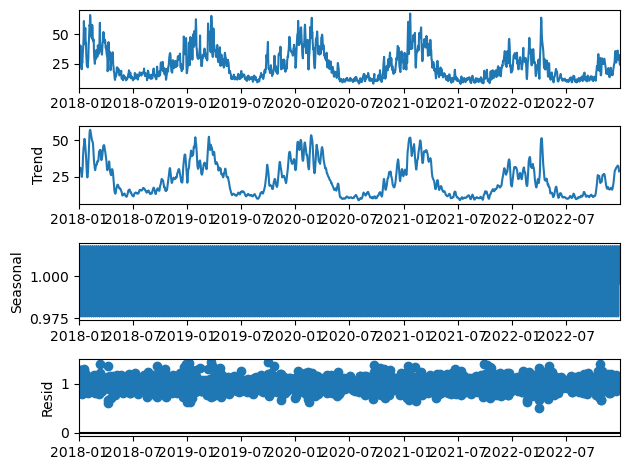

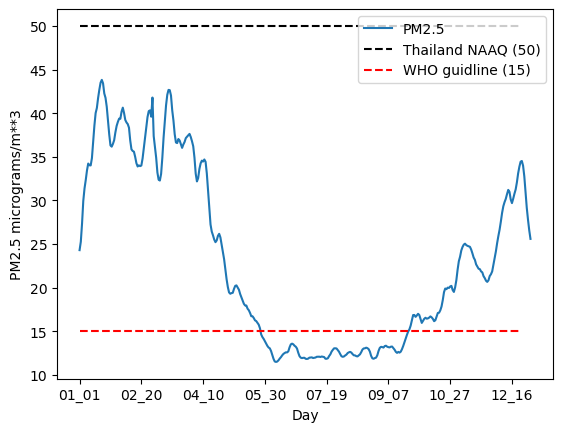

In [125]:
plot_TS_all_year(TS_PM_data, plot_result=True, save_path='./Pics/Seasonality_PM2.5_day.png')

['./Pics/Seasonality_PM2.5_day_label_summer.png', './Pics/Seasonality_PM2.5_day_label_rainny.png', './Pics/Seasonality_PM2.5_day_label_winter.png']


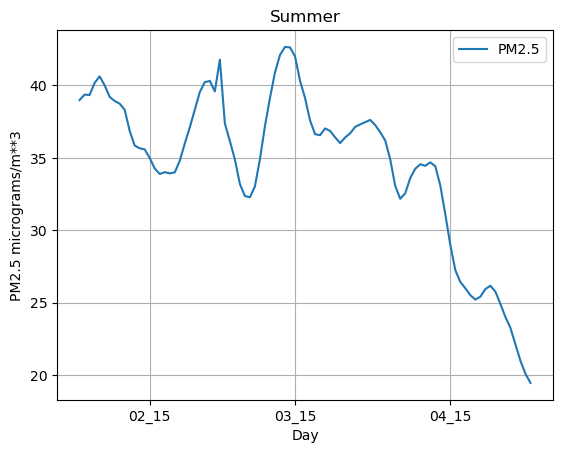

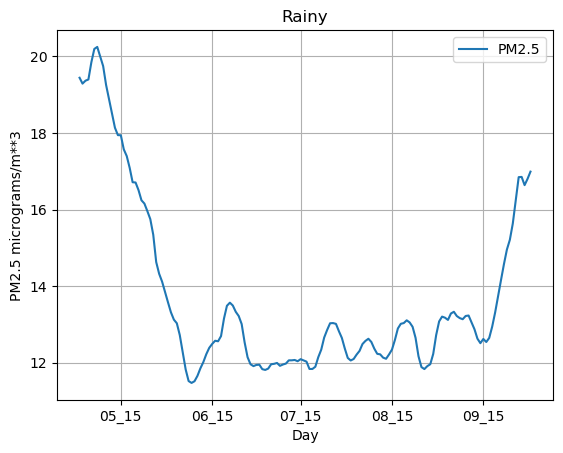

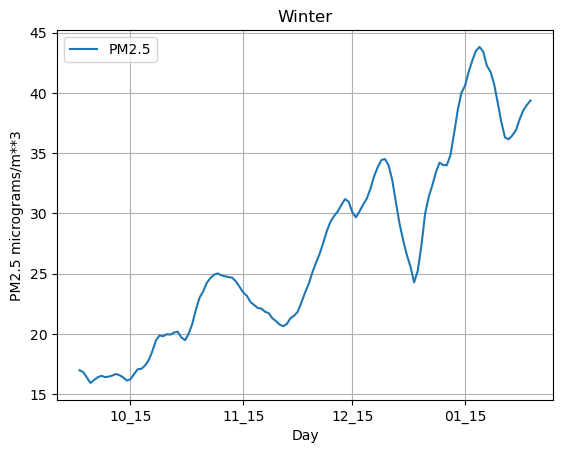

In [129]:
season_save_path = ['./Pics/Seasonality_PM2.5_day_label_summer.png', './Pics/Seasonality_PM2.5_day_label_rainny.png', 
                    './Pics/Seasonality_PM2.5_day_label_winter.png']
plot_TS_3_seasons(TS_PM_data, save_path=season_save_path)

In [130]:
# Top 5 city
station_PM_perYear

,label,station_id,station_name,2020,2021,2018,2022,2019,total
15,49,57T,จ.เชียงราย,35.742445,31.632648,26.741855,21.909226,36.678571,30.540949
14,49,73T,จ.เชียงราย,35.742445,31.632648,26.741855,21.909226,36.678571,30.540949
17,50,35T,จ.เชียงใหม่,30.900641,26.593836,28.167582,21.371978,33.441621,28.095132
16,50,36T,จ.เชียงใหม่,30.900641,26.593836,28.167582,21.371978,33.441621,28.095132
20,54,58T,จ.แม่ฮ่องสอน,32.200549,29.209132,21.868208,22.343407,31.173313,27.358922
4,22,70T,จ.พะเยา,32.085165,25.127397,25.394893,20.494505,31.603508,26.941094
19,53,69T,จ.แพร่,30.892857,24.942466,25.246541,22.430861,30.773633,26.857272
11,32,68T,จ.ลำพูน,27.217033,22.894977,26.373473,21.871566,35.065934,26.684597
1,8,76T,จ.ตาก,27.487179,25.314612,29.090316,20.331319,27.960165,26.036718
13,46,92T,จ.อุตรดิตถ์,0.000000,26.535996,0.000000,23.465195,0.000000,25.000595


In [114]:
mean_PM_city = station_PM_perYear[['station_name', 'total']].groupby(['station_name']).mean().sort_values(['total'], ascending=False)
mean_PM_city

,total
station_name,
จ.เชียงราย,30.540949
จ.เชียงใหม่,28.095132
จ.แม่ฮ่องสอน,27.358922
จ.พะเยา,26.941094
จ.แพร่,26.857272
จ.ลำพูน,26.684597
จ.ตาก,26.036718
จ.อุตรดิตถ์,25.000595
จ.ลำปาง,24.928445


In [115]:
city_PM_perYear = station_PM_perYear.copy().drop(columns=['label', 'station_id']).groupby(['station_name']).mean()
city_PM_perYear = city_PM_perYear.sort_values(['total'], ascending=False)
city_PM_perYear

,2020,2021,2018,2022,2019,total
station_name,,,,,,
จ.เชียงราย,35.742445,31.632648,26.741855,21.909226,36.678571,30.540949
จ.เชียงใหม่,30.900641,26.593836,28.167582,21.371978,33.441621,28.095132
จ.แม่ฮ่องสอน,32.200549,29.209132,21.868208,22.343407,31.173313,27.358922
จ.พะเยา,32.085165,25.127397,25.394893,20.494505,31.603508,26.941094
จ.แพร่,30.892857,24.942466,25.246541,22.430861,30.773633,26.857272
จ.ลำพูน,27.217033,22.894977,26.373473,21.871566,35.065934,26.684597
จ.ตาก,27.487179,25.314612,29.090316,20.331319,27.960165,26.036718
จ.อุตรดิตถ์,0.000000,26.535996,0.000000,23.465195,0.000000,25.000595
จ.ลำปาง,27.345009,24.088242,24.625687,18.939858,29.643429,24.928445


In [116]:
top_5_city = city_PM_perYear.loc[:'จ.แพร่'].reset_index()
top_5_city

,station_name,2020,2021,2018,2022,2019,total
0,จ.เชียงราย,35.742445,31.632648,26.741855,21.909226,36.678571,30.540949
1,จ.เชียงใหม่,30.900641,26.593836,28.167582,21.371978,33.441621,28.095132
2,จ.แม่ฮ่องสอน,32.200549,29.209132,21.868208,22.343407,31.173313,27.358922
3,จ.พะเยา,32.085165,25.127397,25.394893,20.494505,31.603508,26.941094
4,จ.แพร่,30.892857,24.942466,25.246541,22.430861,30.773633,26.857272


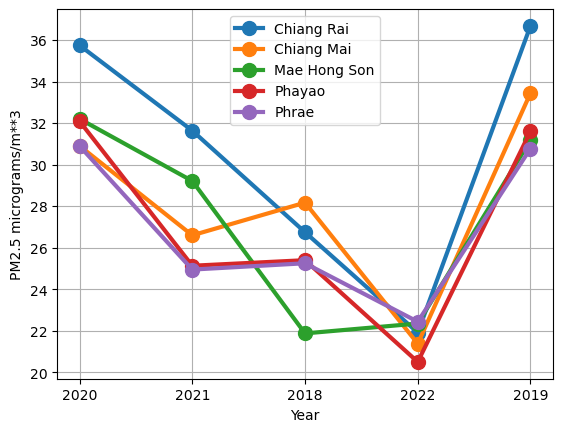

In [131]:
city_name_mapping = {'จ.เชียงราย':'Chiang Rai', 'จ.เชียงใหม่':'Chiang Mai', 'จ.แม่ฮ่องสอน':'Mae Hong Son', 'จ.พะเยา':'Phayao', 'จ.แพร่':'Phrae'}
for i in top_5_city.index:
    a_city = top_5_city.iloc[i].to_numpy()
    city_name = a_city[0]
    city_data = a_city[1:-1]
    plt.plot(top_5_city.columns.to_numpy()[1:-1], city_data, '.-', lw=3, ms=20, label=city_name_mapping[city_name])
plt.ylabel('PM2.5 micrograms/m**3')
plt.xlabel('Year')
plt.grid()
plt.legend()
# plt.savefig('./Pics/PM2.5_year_label_top_5.png')
plt.show()
    